# 🌿 Image Classification with Vision Transformer on Beans Dataset

This notebook demonstrates how to fine-tune a pre-trained Vision Transformer (ViT) model for a plant disease classification task using the **Beans dataset** from Hugging Face Datasets.

The Beans dataset contains high-resolution images of bean leaves, categorized into three classes:
- `healthy`
- `angular_leaf_spot`
- `bean_rust`

### ✅ Key Steps in This Notebook:
- Load and preprocess image data using `transformers` and `datasets`
- Use a pre-trained model: `google/vit-base-patch16-224`
- Fine-tune the model for **5 epochs** using Hugging Face `Trainer`
- Track accuracy and loss across training and validation
- Save and (optionally) push the model to the Hugging Face Hub

> Final validation accuracy achieved: **96.1%**

This is a lightweight, real-world example of how to adapt powerful vision models to small, domain-specific datasets using Hugging Face tools.


In [32]:
# install dependency
# !pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

In [19]:
# set huggingface env
from huggingface_hub import notebook_login

notebook_login()

### 📚 Dataset: Beans

We use the **Beans** dataset from the Hugging Face Hub for a lightweight image classification task. It contains high-resolution images of bean plant leaves labeled into three categories:

- **Healthy**
- **Angular Leaf Spot**
- **Bean Rust**

This dataset is ideal for:
-  Quick experimentation and fine-tuning
-  Demonstrating vision transformer models
-  Low-resource training (small dataset size)



In [3]:
# Load the dataset
from datasets import load_dataset
dataset = load_dataset("beans", split="train")

README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [4]:
# Split datasets
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [5]:
# see the label size and names
label_names = dataset["train"].features["labels"].names
num_labels = len(label_names)

print(f"Number of labels: {num_labels}")
print("Label names:", label_names)

Number of labels: 3
Label names: ['angular_leaf_spot', 'bean_rust', 'healthy']


***To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:***

In [6]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
label2id, id2label

({'angular_leaf_spot': '0', 'bean_rust': '1', 'healthy': '2'},
 {'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'})

### Import image processor to process an image
Here i choose A ViT image processor to process the image into tensor

In [8]:
from transformers import AutoImageProcessor

model_name = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

2025-06-07 07:24:55.886241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749281096.079838      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749281096.135622      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

***Let's do some "Augmentation" , that means appling some image transformations to the images to make the model more robust against overfitting.***

In [9]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [10]:
# Preprocess function for the image
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [11]:
# Now apply the transforms
dataset = dataset.with_transform(transforms)

### Adding DataCollator
here i am using default data collector which does not apply additional preprocessing such as padding unlike data collator from transformers

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

### Setting an Evaluate Metric to see the accuracy

In [13]:
# !pip install evaluate

In [14]:
import evaluate
accuracy = evaluate.load("accuracy")

Creating a ***metrics function*** that passes the predictions and labels to compute to calculate the accuracy:

In [15]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Now Training

In [16]:
# First selecting the model and must Specify the number of labels along with the number of expected labels, and the label mappings
# Using same model similar with image processor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [20]:
training_args = TrainingArguments(
    output_dir="my_bean_model",
    run_name="vit-beans-run-1",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.036400,0.764673,0.874396
2,0.694600,0.421664,0.913043
3,0.429400,0.288738,0.951691
4,0.240500,0.241666,0.937198
5,0.211800,0.228066,0.961353


TrainOutput(global_step=65, training_loss=0.46427847972283, metrics={'train_runtime': 125.759, 'train_samples_per_second': 32.88, 'train_steps_per_second': 0.517, 'total_flos': 3.2043224896349184e+17, 'train_loss': 0.46427847972283, 'epoch': 5.0})

In [22]:
trainer.push_to_hub()

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/TamalSarker777/my_bean_model/commit/33ecdd9cee931bf5c4e3e696142277a1ac35bbe8', commit_message='End of training', commit_description='', oid='33ecdd9cee931bf5c4e3e696142277a1ac35bbe8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TamalSarker777/my_bean_model', endpoint='https://huggingface.co', repo_type='model', repo_id='TamalSarker777/my_bean_model'), pr_revision=None, pr_num=None)

In [23]:
#Evaluate on Test Set
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.2301848828792572, 'eval_accuracy': 0.9516908212560387, 'eval_runtime': 2.2478, 'eval_samples_per_second': 92.089, 'eval_steps_per_second': 5.783, 'epoch': 5.0}


In [24]:
# Save the Model
trainer.save_model("vit-beans-final")
image_processor.save_pretrained("vit-beans-final")


events.out.tfevents.1749281369.333d231d23fa.35.1:   0%|          | 0.00/405 [00:00<?, ?B/s]

['vit-beans-final/preprocessor_config.json']

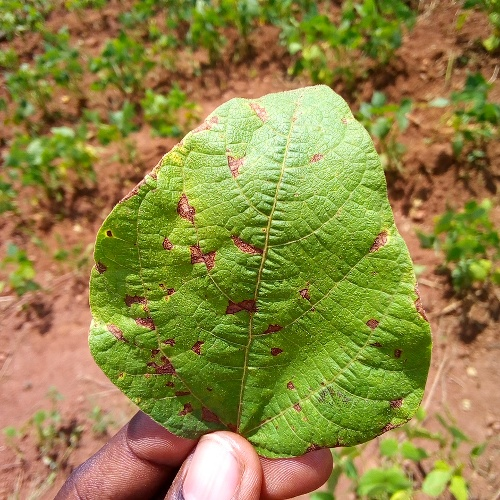

In [27]:
#Load an image to run inference on:
ds = load_dataset("beans", split="validation[:10]")
image = ds["image"][0]
image

In [28]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_bean_model")
classifier(image)

Device set to use cuda:0


[{'label': 'angular_leaf_spot', 'score': 0.8469767570495605},
 {'label': 'bean_rust', 'score': 0.08887208998203278},
 {'label': 'healthy', 'score': 0.06415107846260071}]

### Manually replicate the results of the pipeline

In [29]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_bean_model")
inputs = image_processor(image, return_tensors="pt")

In [30]:
# Pass your inputs to the model and return the logits:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_bean_model")
with torch.no_grad():
    logits = model(**inputs).logits

In [31]:
# See result with converting to label
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'angular_leaf_spot'